### Compare MILAD results to RMSD

This notebook explores how MILAD fingerprints RMSDs compare with results from a brute-force RMSD algorithm in terms of comparing molecules for similarity.

We need this to make sure that comparing the fingerprints is a valid way of saying that two molecules (i.e. original and reconstructed) are the same.

In [1]:
from argparse import Namespace
import json
import random

from ase import visualize
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas
from scipy.spatial.transform import Rotation as R

import milad
from milad.play import asetools
from milad import invariants
from milad import reconstruct


import qm9_utils

Set up seeds and constants

In [2]:
# Seed RNGs
random.seed(1234)
np.random.seed(1234)

# Colours used for plotting
cmap=('#845ec2',  '#FF9D47', '#ff9671')

# Parameters passed to reconstruct.get_best_rms
rmsd_settings = dict(
    max_retries=1,
    max_attempts=80000,
    threshold=1e-3,
    use_hungarian=True,
)

Load the QM9 database

In [3]:
from schnetpack import datasets

qm9data = datasets.QM9('data/qm9.db', download=True)
len(qm9data)

133885

In [4]:
cutoff = 5

# Invariants to use
invs = invariants.read(invariants.COMPLEX_INVARIANTS)
# Let's create the descriptor we're going to use
descriptor = qm9_utils.create_descriptor(invs, cutoff, apply_cutoff=False)

Load out datasets

In [5]:
with open('data/qm9_subset.json', 'r') as subset:
    test_set = json.load(subset)
test_set = {int(key): value for key, value in test_set.items()}

In [6]:
no_species = pandas.read_pickle('structure_recovery_iterative_no_species.pickle')
with_species = pandas.read_pickle('structure_recovery_iterative_with_species.pickle')
with_species_two_fingerprints = pandas.read_pickle('species_recovery_from_decoded_positions.pickle')

First let's see how reliable RMSD based comparisons of molecules are

In [7]:
def get_milad_vs_rmsd(dataset, rmsd_settings, include_species=True, num_rotations=5):
    milad_rmsds = []
    rdkit_rmsds = []
    for size, idxs in sorted(test_set.items()):       
        for idx in idxs:
            reference = asetools.ase2milad(dataset.get_atoms(idx=idx))
            if not include_species:
                reference.numbers = 1.
            reference_fp = descriptor(reference)

            for i in range(num_rotations):
                r = R.random()
                atoms = reference.copy()

                # Apply random rotation
                atoms.positions = r.apply(atoms.positions)
                # Apply random shuffling of indices
                new_indices = list(range(size))
                random.shuffle(new_indices)
                atoms.positions = atoms.positions[new_indices]
                atoms.numbers = atoms.numbers[new_indices]

                milad_diff = reference_fp - descriptor(atoms)
                milad_rmsd = np.sqrt(np.mean(milad_diff**2))
                rdkit_rmsd = milad.reconstruct.get_best_rms(reference, atoms, **rmsd_settings)

                milad_rmsds.append([size, milad_rmsd])
                rdkit_rmsds.append([size, rdkit_rmsd])
    
    return np.array(milad_rmsds), np.array(rdkit_rmsds)


def get_rmsd_ranges(qm9data, test_set, rmsd_settings, include_species=True):
    """This function calculates the RMSD between different molecules of the same size to give an indication
    of the RMSD value that we can expect when two molecules are different"""
    min_max = []
    for size, idxs in sorted(test_set.items()):
        num_mols = len(idxs)
        
        rmsds = []
        for i in range(num_mols):
            atoms_i = asetools.ase2milad(qm9data.get_atoms(idx=idxs[i]))
            if not include_species:
                atoms_i.numbers = 1.
            
            for j in range(i + 1, num_mols):
                atoms_j = asetools.ase2milad(qm9data.get_atoms(idx=idxs[j]))
                if not include_species:
                    atoms_j.numbers = 1.
                
                rmsd = milad.reconstruct.get_best_rms(atoms_i, atoms_j, **rmsd_settings)
                rmsds.append(rmsd)
        
        mean = np.mean(rmsds)
        print(np.min(rmsds))
        min_max.append((size, mean, mean - np.min(rmsds), np.max(rmsds) - mean))
    
    return np.array(min_max)

In [8]:
no_species_comparison = get_milad_vs_rmsd(qm9data, rmsd_settings, include_species=False)
with_species_comparison = get_milad_vs_rmsd(qm9data, rmsd_settings, include_species=True)

In [9]:
no_species_minmax = get_rmsd_ranges(qm9data, test_set, rmsd_settings, include_species=False)

0.402050612159543
0.2537596897403264
0.8716077021419059
0.3668452277449597
0.388589865170804
0.8025565036216067
0.6887524007246336
0.9881072724578741
0.702339600493294
0.7466991519211769
0.5788449475780197
0.9349888376664426
0.9737909399114418
0.5313942991010342
1.1730946160587608
1.1960494427192347
0.48334448925541956
1.1468087498432882
0.9631313425393969
1.028633558051429
0.8205809550916864
1.0354196229386412
1.0282474560808612
0.9416621826989129
1.1719399354095508
1.5131507707431306


<ipython-input-32-0e48df24f55c>:50: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


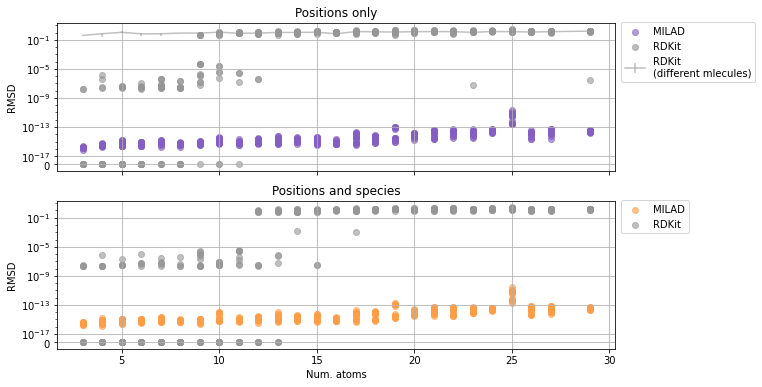

In [32]:
rdkit_colour = '#969696'

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 6), squeeze=True)

ax1.scatter(no_species_comparison[0][:, 0], no_species_comparison[0][:, 1], c=cmap[0], alpha=0.6, label='MILAD')
ax1.scatter(
    no_species_comparison[1][:, 0],
    no_species_comparison[1][:, 1],
    c=rdkit_colour,
    alpha=0.6,
    label='RDKit', marker='o',
)
ax1.errorbar(
    no_species_minmax[:, 0],
    no_species_minmax[:, 1],
    no_species_minmax[:, 2:].T,
    c=rdkit_colour, alpha=0.6, label='RDKit\n(different mlecules)')


ax1.set_title('Positions only')

ax2.scatter(
    with_species_comparison[0][:, 0],
    with_species_comparison[0][:, 1],
    c=cmap[1], alpha=0.6, label='MILAD')
ax2.scatter(
    with_species_comparison[1][:, 0],
    with_species_comparison[1][:, 1],
    c=rdkit_colour, alpha=0.6, marker='o', label='RDKit')
ax2.set_title('Positions and species')

ax2.set_xlabel('Num. atoms')
for ax in (ax1, ax2):
    ax.grid('on')
    ax.set_yscale('symlog', linthresh=1e-17)
    ax.set_ylabel('RMSD')


ax1.legend(loc=(1.01, 0.60))
ax2.legend(loc=(1.01, 0.78))

# Shared axis settings
ticker = matplotlib.ticker.SymmetricalLogLocator(base=10, linthresh=1e-17)
ticker.set_params(subs=[1.0], numticks=6)
ax1.yaxis.set_major_locator(ticker)

fig.subplots_adjust(wspace=0.05)
# fig.tight_layout()

fig.show()
fig.savefig('img/rmsd_values.pdf', bbox_inches='tight')

In [11]:
include_species = False
dataset = with_species if include_species else no_species

def get_rmsd_comparison(dataset, test_set, rmsd_settings, max_size, chiral_threshold, include_species=True):
    milad_rmsds = []
    rdkit_rmsds = []
    rdkit_reflected_rmsds = []
    
    for size, idxs in sorted(test_set.items()):
        if size > max_size:
            # Only go up to this many atoms
            break
            
        for idx in idxs:
            reference = asetools.ase2milad(qm9data.get_atoms(idx=idx))
            if not include_species:
                reference.numbers = 1.

            # Get the milad result
            result = qm9_utils.get_best_reconstruction(idx, dataset)['Result'].iloc[0]
            milad_rmsds.append((int(idx), result.rmsd))
            
            atoms = result.value.copy()
            if not include_species:
                atoms.numbers = 1.
            
            rdkit_rmsd = milad.reconstruct.get_best_rms(reference, atoms, **rmsd_settings)
            rdkit_rmsds.append((int(idx), rdkit_rmsd))
            
            if rdkit_rmsd > chiral_threshold:
                # Point reflect
                atoms.positions = -atoms.positions
                rdkit_rmsd = milad.reconstruct.get_best_rms(reference, atoms, **rmsd_settings)
                rdkit_reflected_rmsds.append((idx, rdkit_rmsd))

    results = Namespace()
    results.milad_rmsds = np.array(milad_rmsds)
    results.rdkit_rmsds = np.array(rdkit_rmsds)
    results.rdkit_reflected_rmsds = np.array(rdkit_reflected_rmsds)
    
    return results

In [14]:
threshold = 0.25
max_num_atoms = 11
no_species_results = get_rmsd_comparison(
    no_species, test_set, rmsd_settings, max_size=max_num_atoms,  
    chiral_threshold=threshold, include_species=False)
with_species_results = get_rmsd_comparison(
    with_species, test_set, rmsd_settings, max_size=max_num_atoms, chiral_threshold=threshold)
with_species_two_fingerprints_results = get_rmsd_comparison(
    with_species_two_fingerprints, test_set, rmsd_settings, max_size=max_num_atoms, chiral_threshold=threshold)

<ipython-input-33-201fd0ec5c27>:71: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


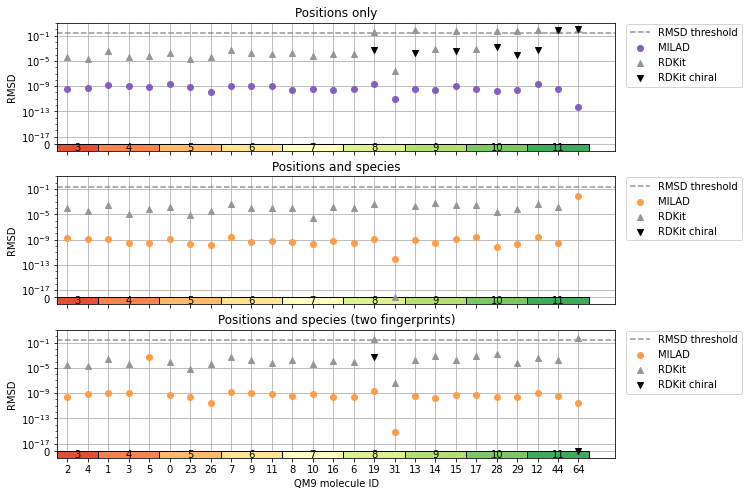

In [33]:
def plot_comparison(axis, results, colour, threshold=0.25, ylabel=True, xlabel=True):
    axis.grid('on')
    
    def int_str(value):
        return str(int(value))
    
    axis.scatter(
        tuple(map(int_str, results.milad_rmsds[:, 0])),
        results.milad_rmsds[:, 1],
        c=colour, label='MILAD', zorder=5)
    axis.scatter(
        tuple(map(int_str, results.rdkit_rmsds[:, 0])),
        results.rdkit_rmsds[:, 1],
        c=rdkit_colour, label='RDKit', marker='^', zorder=5)
    axis.scatter(
        tuple(map(int_str, results.rdkit_reflected_rmsds[:, 0])),
        results.rdkit_reflected_rmsds[:, 1],
        c='black', label='RDKit chiral', marker='v', zorder=5)

    # Add the reconstrction threshold line
    axis.axhline(y=threshold, xmin=0, xmax=np.max(results.milad_rmsds[:, 0]),
               linestyle='dashed', color=rdkit_colour, label='RMSD threshold')
    
    if xlabel:
        axis.set_xlabel('QM9 molecule ID')
    if ylabel:
        axis.set_ylabel('RMSD')
    axis.set_yscale('symlog', linthresh=1e-17)
    axis.set_ylim([-1e-17, 10])

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(10, 8), squeeze=True)
    
plot_comparison(ax1, no_species_results, colour=cmap[0], xlabel=False)
plot_comparison(ax2, with_species_results, colour=cmap[1], xlabel=False)
plot_comparison(ax3, with_species_two_fingerprints_results, colour=cmap[1])

ax1.set_title('Positions only')
ax2.set_title('Positions and species')
ax3.set_title('Positions and species (two fingerprints)')
fig.subplots_adjust(wspace=0.05)

sizes = np.array(
    [(num_atoms, len(idxs))
     for num_atoms, idxs 
     in sorted(test_set.items()) 
     if num_atoms <= max_num_atoms]
)

# Plot bars to indicate number of atoms
labels = []
widths = []
starts = []
category_colors = plt.get_cmap('RdYlGn')( np.linspace(0.15, 0.85, len(sizes)))
for size, num in sizes:
    starts.append(sum(widths) - 0.5)
    labels.append(str(size))
    widths.append(num) 

for ax in (ax1, ax2, ax3):
    # Bar showing numbers of atoms in each molecule
    rects = ax.barh(-5e-18, widths, height=1e-17, left=starts, color=category_colors, edgecolor='black', zorder=2)
    ax.bar_label(rects, labels=labels, label_type='center', color='black', zorder=2)
    ax.legend(loc=(1, 1), ncol=1, bbox_to_anchor=(1.02, 0.5))
    
# Axis settings
ticker = matplotlib.ticker.SymmetricalLogLocator(base=10, linthresh=1e-17)
ticker.set_params(subs=[1.0], numticks=6)
ax1.yaxis.set_major_locator(ticker)

fig.subplots_adjust(wspace=0.1)
fig.show()
fig.savefig('img/rmsd_comparison.pdf', bbox_inches='tight')